# Accuracy vs. GT shift

author: steeve.laquitaine@epfl.ch

purpose: find the true spikes timestamp shift that maximizes overall sorting accuracy.

rationale: the simulator timestamps spikes (when voltage reaches (-10uV) and the spike sorter might be timestamping spike at a different location.

Methods:

1. For each ground truth unit, shift its spikes timestamp by a constant shift, calculate its agreement score with each sorted unit, select the max agreement score over sorted units as the ground truth unit's sorting accuracy.

2. Repeat for all ground truth units.

3. Calculate overall sorting accuracy as the proportion of ground truth units with an agreement score >= 0.8.

* detailed analysis

* For a given ground truth unit:
    * For a given value of delta t:
        * Calculate the agreement score between the ground truth unit and all sorted units, after shifting their times by a constant delta t Find the sorted unit with the highest agreement score. Note what that agreement score is. Note which sorted unit it is obtained by.

    * Then plot delta t vs. highest agreement score obtained for 10 to 100 ground truth units. Do the scores peak for a specific delta t? Is that delta t consistent between units? At what points does it shift from one sorted unit being the best match to another? Also interesting: What is the expected value of the max. agreement score for very large values of delta t. That can serve as a control for determining the "chance level" agreement score

Conclusion:
* we will increase delta_time from the default 0.4 ms to 1.3 ms, because it maximizes unit accuracy (it doubles it, panel f), while still discarding sorted unit timestamps that could be in the vicinity of the ground truth spike by chance (multiple peaks in the distribution of the max accuracy - accuracy at maximal shift, indicative of chance level matches (peak at 0) and above chance level (other peaks) instead of a single peak at 0 (chance level match, panel g)). 

## Setup

activate spikeinterf...

In [46]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
import spikeinterface as si 
from spikeinterface.comparison import compare_sorter_to_ground_truth as comp

# SILICO MARQUES
cfg, _ = get_config("silico_neuropixels", "concatenated").values()
GT_PATH = cfg["sorting"]["simulation"]["ground_truth"]["output"]
SFREQ = 40000

# SORTINGS

# kilosort 3.0
S_PATH = cfg["sorting"]["sorters"]["kilosort3"]["10m"]["output_buttw_noise_fitd"]
ACC_DT_SHIFT_PATH = cfg["analyses"]["acc_dt_shift"]

# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.05)
LG_FRAMEON = False  # no legend frame
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 1.1
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.major.width"] = 0.8 * 1.3
plt.rcParams["ytick.major.width"] = 0.8 * 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent": True, "dpi": 300}  # dpi=300 minimum for publication
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.1}
labels_cfg = {"labelpad":0}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-06-11 19:08:31,062 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-11 19:08:31,136 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (1m) Unit accuracies

first 10 minutes of the recordings

In [9]:
def get_shift_in_samples(shift_microsec: float, sfreq: int):

    # sampling time unit
    sampling_timestep = 1 / sfreq * 1000000

    # do not shift, if the input shift is the sampling timestep
    if np.absolute(shift_microsec) < sampling_timestep:
        samples = 0
        print(
            f"Spike train was not shifted, the shift {shift_microsec} < sampling timestep {sampling_timestep}"
        )
    else:
        # convert shift from microseconds to samples
        us0_1 = 1 * sfreq / 1000000  # nb of samples for 0.1ms
        samples = shift_microsec * us0_1
    return int(samples)


def acc_for_shift(
    TrueUnit, Sorted, true_unit_id, shift_microsec, delta_time, sfreq, verbose: bool
):
    """_summary_

    Args:
        TrueUnit (_type_): _description_
        Sorted (_type_): _description_
        true_unit_id (_type_): _description_
        shift_microsec (_type_): _description_
        delta_time (_type_): _description_
        sfreq (_type_): _description_
        verbose (bool): _description_

    Returns:
        dict: _description_
        - true unit accuracy: maximal accuracy (agreement score
        with a sorted unit) found for this shift
    """

    # convert shift to nb of samples
    shift_smp = get_shift_in_samples(shift_microsec, sfreq)

    # 1. shift the true unit spike train
    unit_peak_shifts = {true_unit_id: shift_smp}
    TrueUShifted = si.postprocessing.align_sorting(TrueUnit, unit_peak_shifts)

    # 2. agreement score b/w the true and all sorted units
    CompObj = comp(
        TrueUShifted,
        Sorted,
        exhaustive_gt=True,
        delta_time=delta_time,
    )
    unit_acs = CompObj.agreement_scores

    # find true unit accuracy (max ag. score)
    # check whether many sorted units are equal matches
    unit_acs_arr = unit_acs.values.squeeze()
    true_u_acc = unit_acs_arr.max()
    argsmax = np.where(unit_acs_arr == true_u_acc)[0]

    # number of matched sorted units
    matchs = unit_acs.columns[argsmax].values.tolist()

    # log
    if verbose:
        print("shift:", shift_smp, "samples")
        print("nb equally matched sorted units:", len(argsmax))
        print("true unit accuracy:", true_u_acc)

    return {
        "true_unit_ac": true_u_acc,
        "matchs": matchs,
        "unit_acs": unit_acs,
    }


def get_detailed_acc_data_by_shift(
    TrueUnit, Sorted, true_unit_id, delta_time, sfreq, shift_set, verbose
):
    """_summary_

    Args:
        TrueUnit (_type_): _description_
        Sorted (_type_): _description_
        true_unit_id (_type_): _description_
        delta_time (_type_): _description_
        sfreq (_type_): _description_
        shift_set (_type_): _description_
        verbose (_type_): _description_

    Returns:
        dict: _description_
        - accs: maximal accuracies found for each tested shift
    """
    data = []
    accs = []
    matchs = []
    n_matchs = []

    # test different shifts
    for s_i in shift_set:
        out = acc_for_shift(
            TrueUnit, Sorted, true_unit_id, s_i, delta_time, sfreq, verbose=verbose
        )
        data.append(out)
        accs.append(out["true_unit_ac"])
        matchs.append(out["matchs"])
        n_matchs.append(len(out["matchs"]))
    return {"accs": accs, "matchs": matchs, "n_matchs": n_matchs, "data": data}


def get_true_unit_max_acc_data(accuracies, shift_set: np.array, matchs):
    """find the max accuracy, the shift(s) and sorted units that produced it"""
    max_a = max(accuracies)
    acc_argmax = np.where(accuracies == max_a)[0]
    shifts = shift_set[acc_argmax]
    try:
        sorted_matchs = [matchs[ix] for ix in range(len(matchs)) if ix in acc_argmax]
    except:
        from ipdb import set_trace

        set_trace()
    return {
        "max_acc": max_a,
        "shifts_with_max_acc": shifts,
        "matchs_with_max_acc": sorted_matchs,
    }


def get_all_units_acc_by_shift_data(
    GTrue, Sorted, delta_time, sfreq, shift_set, n_smp, verbose
):
    """calculate all the data per unit for accuracy by shift

    Args:
        GTrue (_type_): _description_
        Sorted (_type_): _description_
        delta_time (_type_): _description_
        sfreq (_type_): _description_
        shift_set (_type_): _description_
        n_smp: number of units
        verbose (_type_): _description_

    Returns:
        dict: _description_
        - shift_data_all.keys() are true unit ids
    """

    # store detailed accuracy data
    # for all true units
    shift_data_all = {}
    accs_data_all = {}

    # loop over true units
    for u_i in GTrue.unit_ids[:n_smp]:

        # create sorting extractor
        TrueUnit = GTrue.select_units([u_i])

        # get detailed accuracy data for all the shifts
        shift_data_all[u_i] = get_detailed_acc_data_by_shift(
            TrueUnit, Sorted, u_i, delta_time, sfreq, shift_set, verbose=verbose
        )

        # get accuracy data for best sorted unit matches and best shifts
        accs_data_all[u_i] = get_true_unit_max_acc_data(
            shift_data_all[u_i]["accs"], shift_set, shift_data_all[u_i]["matchs"]
        )
    return {"shift_data": shift_data_all, "acc_data": accs_data_all}


def get_all_units_acc_dt_shift_data(
    GTrue,
    Sorted,
    shift_set,
    dt_set,
    n_smp,
    sfreq,
    save: bool,
    save_path: str,
    verbose: bool,
):
    """calculate the accuracy for all ground truth units
    against different test delta_times, and shifts

    Args:
        GTrue (SortingExtractor): Ground truth data
        Sorted (SortingExtractor): Sorted data
        shift_set (list): the shifts used for ground truth unit spike trains
        n_smp (int): number of selected ground truth units
        sfreq (int): trace acquisition sampling frequency
        save (bool): _description_
        save_path (str): _description_
        verbose (bool): _description_

    Returns:
        dict: _description_
        - all computed data
    """
    data_dt = {}
    for _, dt in enumerate(dt_set):
        data_dt[dt] = get_all_units_acc_by_shift_data(
            GTrue, Sorted, dt, sfreq, shift_set, n_smp, verbose=verbose
        )
    if save:
        parent_path = os.path.dirname(save_path)
        if not os.path.isdir(parent_path):
            os.makedirs(parent_path)
        np.save(save_path, data_dt, allow_pickle=True)
    return data_dt

### Load dataset

In [5]:
# select first 10 minutes to match traces
GTrue = si.load_extractor(GT_PATH).frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ)
Sorted = si.load_extractor(S_PATH).frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ)

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


### (6m)Parameters

* 100 true units takes 6m to compute.

* si.postprocessing.align_sorting shifts a spike train timestamps by a constant offset sample, SHIFT (>0 / <0 subtracts/adds SHIFT to the original timestamps).

* note: for a true unit could 5 shifts could produce the same max accuracy of 0.4285: (-500, -400, -300, -200, -100, 0,  100,  200,  300). Each shift could produce several best sorted unit match. In that example, each shift produced one best sorted match only. 

In [6]:
# in microseconds (0 produces original spike train; for 40 Khz should be > 1/40,000)
shift_set = np.arange(-10000, 10000, 100)
dt_set = [0.2, 0.4, 0.6, 0.8, 1.3, 5, 30]
n_smp = 50

### (22m)Compute

* 30m for n_smp = 50 neurons

In [10]:
# compute and save
# data_dt = get_all_units_acc_dt_shift_data(
#     GTrue, Sorted, shift_set, dt_set, n_smp, SFREQ, True, ACC_DT_SHIFT_PATH, False
# )

# or load
data_dt = np.load(ACC_DT_SHIFT_PATH, allow_pickle=True)

Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike train was not shifted, the shift 0 < sampling timestep 25.0
Spike trai

### Plot

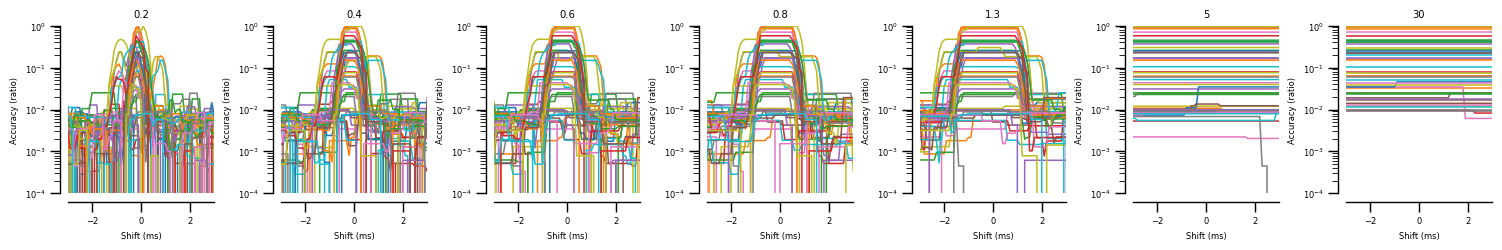

In [11]:
xlim = (-10, 10)

fig, ax = plt.subplots(1, len(dt_set), figsize=(15, 2.5))

for di, dt in enumerate(dt_set):
    for u_i in GTrue.unit_ids[:n_smp]:
        ax[di].plot(shift_set / 1000, data_dt[dt]["shift_data"][u_i]["accs"])

    # legend
    ax[di].set_yscale("log")
    ax[di].set_ylim([10e-5, 1])
    ax[di].set_xlabel("Shift (ms)")
    ax[di].set_ylabel("Accuracy (ratio)")
    ax[di].spines[["top", "right"]].set_visible(False)

    # disconnect axes (R style)
    ax[di].spines["bottom"].set_position(("axes", -0.05))
    ax[di].yaxis.set_ticks_position("left")
    ax[di].spines["left"].set_position(("axes", -0.05))
    ax[di].set_title(dt)
    ax[di].set_xlim((-3, 3))

fig.tight_layout()

a shift of 0.2ms misses some spikes, and does not achieves the maximal achievable accuracy (given the constraint that the accuracy curves should decrease as we move away from their peak).

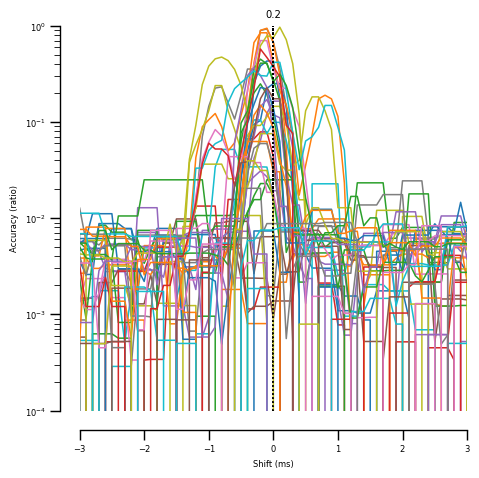

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for u_i in GTrue.unit_ids[:n_smp]:
    ax.plot(shift_set / 1000, data_dt[dt_set[0]]["shift_data"][u_i]["accs"])
    # legend
    ax.set_yscale("log")
    ax.set_ylim([10e-5, 1])
    ax.set_xlabel("Shift (ms)")
    ax.set_ylabel("Accuracy (ratio)")
    ax.spines[["top", "right"]].set_visible(False)

    # disconnect axes (R style)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.yaxis.set_ticks_position("left")
    ax.spines["left"].set_position(("axes", -0.05))
    ax.set_title(dt_set[0])
    ax.set_xlim((-3, 3))
    ax.vlines(x=0, ymin=1e-4, ymax=1, linestyle=":", color="k")

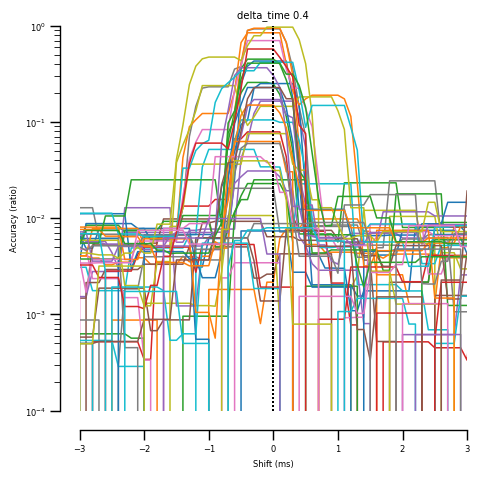

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for u_i in GTrue.unit_ids[:n_smp]:
    ax.plot(shift_set / 1000, data_dt[dt_set[1]]["shift_data"][u_i]["accs"])
    # legend
    ax.set_yscale("log")
    ax.set_ylim([10e-5, 1])
    ax.set_xlabel("Shift (ms)")
    ax.set_ylabel("Accuracy (ratio)")
    ax.spines[["top", "right"]].set_visible(False)

    # disconnect axes (R style)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.yaxis.set_ticks_position("left")
    ax.spines["left"].set_position(("axes", -0.05))
    ax.set_title(f"delta_time {dt_set[1]}")
    ax.set_xlim((-3, 3))
    ax.vlines(x=0, ymin=1e-4, ymax=1, linestyle=":", color="k")

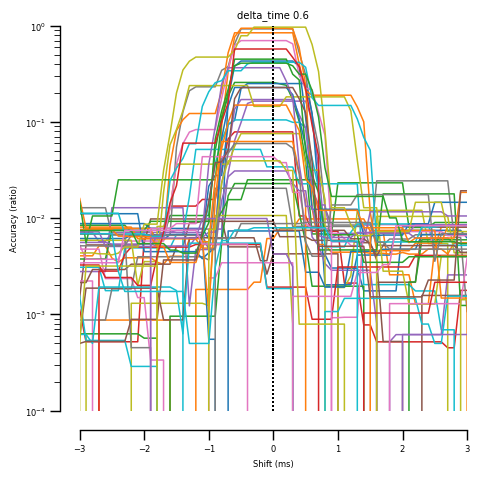

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for u_i in GTrue.unit_ids[:n_smp]:
    ax.plot(shift_set / 1000, data_dt[dt_set[2]]["shift_data"][u_i]["accs"])
    # legend
    ax.set_yscale("log")
    ax.set_ylim([10e-5, 1])
    ax.set_xlabel("Shift (ms)")
    ax.set_ylabel("Accuracy (ratio)")
    ax.spines[["top", "right"]].set_visible(False)

    # disconnect axes (R style)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.yaxis.set_ticks_position("left")
    ax.spines["left"].set_position(("axes", -0.05))
    ax.set_title(f"delta_time {dt_set[2]}")
    ax.set_xlim((-3, 3))
    ax.vlines(x=0, ymin=1e-4, ymax=1, linestyle=":", color="k")

# KEEP THIS FIGURE FOR THE PAPER

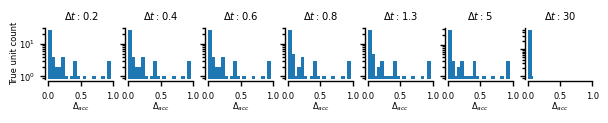

In [73]:
import matplotlib


fig, ax = plt.subplots(1, len(dt_set), figsize=(5.9, 1.05))

# loop over delta_times
for di, dt in enumerate(dt_set):
    max_accs = []
    a_max_shift_maxs = []

    # loop of true units
    for u_i in GTrue.unit_ids[:n_smp]:

        # get maximal accuracy for this delta_time
        a_max = max(data_dt[dt]["shift_data"][u_i]["accs"])

        # get accuracy at the maximal shift for this delta_time
        a_max_shift_max = data_dt[dt_set[di]]["shift_data"][u_i]["accs"][-1]

        # store
        max_accs.append(a_max)
        a_max_shift_maxs.append(a_max_shift_max)

    # plot
    ax[di].hist(np.array(max_accs) - np.array(a_max_shift_maxs), bins=20, width=0.06)

    # legend
    ax[di].set_xlabel("$\Delta_{acc}$", **labels_cfg)
    if di == 0:
        ax[di].set_ylabel("True unit count", **labels_cfg)
    ax[di].set_title(f"delta_time {dt}")
    ax[di].spines[["top", "right"]].set_visible(False)
    # log
    ax[di].set_yscale("log")
    if not di == 0:
        ax[di].set_yticks([1, 10], ["", ""])
    # show minor ticks
    ax[di].tick_params(which="both", width=1)
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
    ax[di].yaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    ax[di].yaxis.set_minor_locator(locmin)
    ax[di].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # disconnect axes (R style)
    ax[di].spines["bottom"].set_position(("axes", -0.05))
    ax[di].yaxis.set_ticks_position("left")
    ax[di].spines["left"].set_position(("axes", -0.05))
    ax[di].set_title(f"$\Delta t:${dt_set[di]}")
    ax[di].set_xlim([-0, 1])
    # tight
    fig.tight_layout(**tight_layout_cfg)

# save figure
plt.savefig(
    "figures/6_supp/fig5/svg/acc_shift_dt.svg",
    **savefig_cfg,
)

# References

https://spikeinterface.readthedocs.io/en/0.100.5/modules/comparison.html?highlight=comparison

https://spikeinterface.readthedocs.io/en/0.100.5/api.html?highlight=delta_time#spikeinterface.comparison.compare_two_sorters